<h1><center>Проект Скважины</center></h1>


# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

    geo_data_0.csv
    geo_data_1.csv
    geo_data_2.csv
    id — уникальный идентификатор скважины;
    f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
    product — объём запасов в скважине (тыс. баррелей).

# Содержание

    1. Загрузка и подготовка данных
    2. Обучение и проверка модели
    3. Подготовка к расчёту прибыли
    4. Расчёт прибыли и рисков 
    5. Общий вывод

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings

In [2]:
region_1 = pd.read_csv('/datasets/geo_data_0.csv')

print()
print('----------- Данные по первому региону -----------')
print()

region_1.info()
display(region_1.head())


----------- Данные по первому региону -----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
region_2 = pd.read_csv('/datasets/geo_data_1.csv')

print()
print('----------- Данные по второму региону -----------')
print()

region_2.info()
display(region_2.head())


----------- Данные по второму региону -----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
region_3 = pd.read_csv('/datasets/geo_data_2.csv')

print()
print('----------- Данные по третьему региону -----------')
print()

region_3.info()
display(region_3.head())


----------- Данные по третьему региону -----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


---
    
- Данные загружены
    
    
- Количество строк и столбцов одинаковое для датасетов по каждому из регионов


- Оценим распределения признаков для каждого из регионов
---

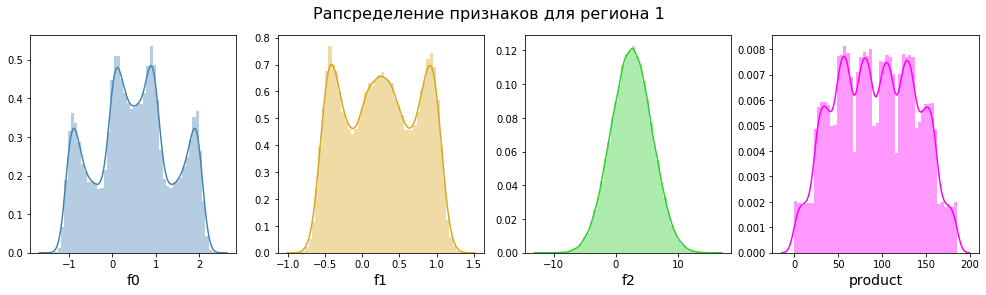

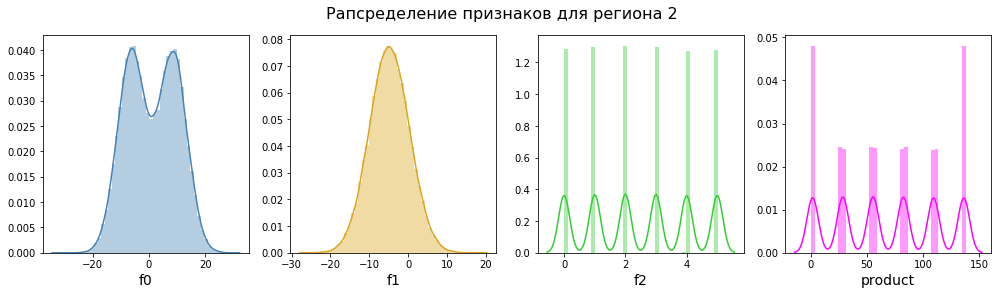

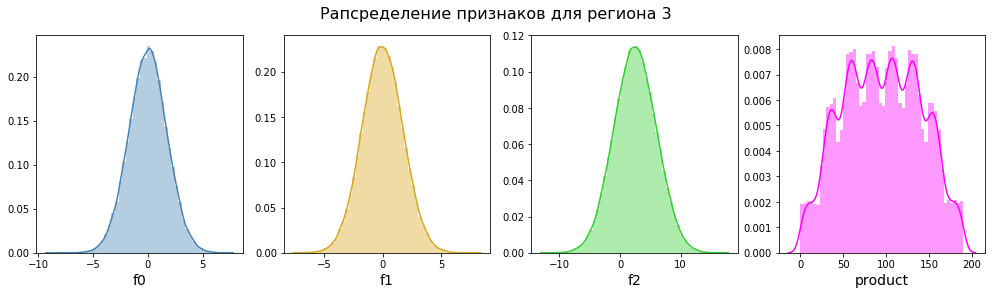

In [5]:
def plot_geo_data(region, title):

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(17, 4))

    sns.distplot(region['f0'], ax=ax1, color='steelblue')
    sns.distplot(region['f1'], ax=ax2, color='goldenrod')
    sns.distplot(region['f2'], ax=ax3, color='limegreen')
    sns.distplot(region['product'], ax=ax4, color='magenta')
    
    ax1.set_xlabel('f0', fontsize=14)
    ax2.set_xlabel('f1', fontsize=14)
    ax3.set_xlabel('f2', fontsize=14)
    ax4.set_xlabel('product', fontsize=14)
    
    fig.suptitle(title, fontsize=16)
    plt.show()

title_1 = 'Рапсределение признаков для региона 1'
plot_geo_data(region_1, title_1)

title_2 = 'Рапсределение признаков для региона 2'
plot_geo_data(region_2, title_2)

title_3 = 'Рапсределение признаков для региона 3'
plot_geo_data(region_3, title_3)

---
    
- Оценим корреляции признаков для каждого из регионов

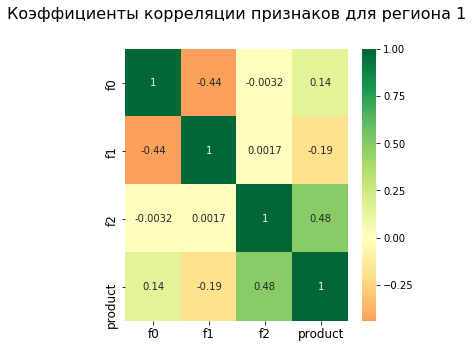

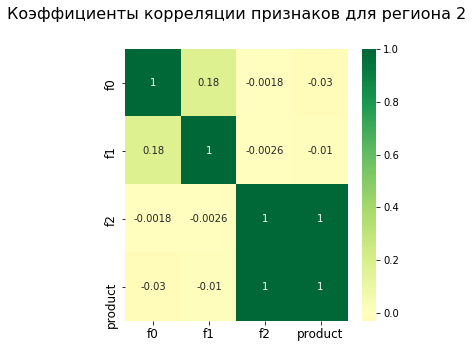

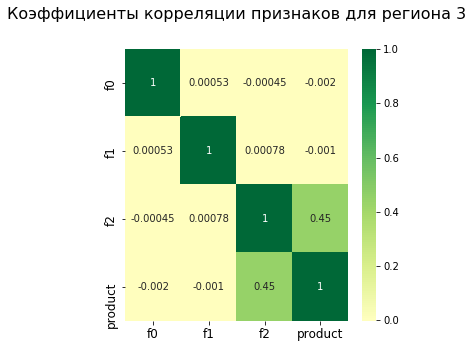

In [6]:
def corr_geo_data(features, title):

    plt.figure(figsize=(5,5))
    sns.heatmap(features.corr(), xticklabels=features.corr().columns, yticklabels=features.corr().columns, cmap='RdYlGn', center=0, annot=True)

    plt.title(title, fontsize=16, pad=30)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    
title_1 = 'Коэффициенты корреляции признаков для региона 1'
corr_geo_data(region_1[['f0', 'f1', 'f2', 'product']], title_1)

title_2 = 'Коэффициенты корреляции признаков для региона 2'
corr_geo_data(region_2[['f0', 'f1', 'f2', 'product']], title_2)

title_3 = 'Коэффициенты корреляции признаков для региона 3'
corr_geo_data(region_3[['f0', 'f1', 'f2', 'product']], title_3)

---

- Для первого региона наблюдается умеренная корреляция между признками f0 и f1, также между f2 и product


- Для второго региона наблюдается полная корреляция между признаками f2 и product, что говорит о функциональной зависимости между этими переменными


- Для третьего региона характерна умеренная корреляция между признками f2 и product

---

# 2. Обучение и проверка модели

---

- Перед началом исследования зададим значение генератора псевдослучаных значений

---

In [7]:
random_state = 12345

---

- Разобъем данные по регионам на обучающую и тестовую выборки в соотношении 75:25

---

In [8]:
target_1 = region_1['product']
features_1 = region_1[['f0', 'f1', 'f2']]

target_2 = region_2['product']
features_2 = region_2[['f0', 'f1', 'f2']]

target_3 = region_3['product']
features_3 = region_3[['f0', 'f1', 'f2']]


features_train_1, features_test_1, target_train_1, target_test_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=random_state)

features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=random_state)

features_train_3, features_test_3, target_train_3, target_test_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=random_state)

---

- Обучим модели линейной регресси на тестовых выборках 

---

In [9]:
model_1 = LinearRegression()
model_2 = LinearRegression()
model_3 = LinearRegression()


model_1.fit(features_train_1, target_train_1)
model_2.fit(features_train_2, target_train_2)
model_3.fit(features_train_3, target_train_3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

---

- Рассчитаем предсказания моделей на валидационных выборках

---

In [10]:
predicted_product_1 = model_1.predict(features_test_1)
predicted_product_2 = model_2.predict(features_test_2)
predicted_product_3 = model_3.predict(features_test_3)


predicted_product_1 = pd.Series(data=predicted_product_1, index=target_test_1.index)
predicted_product_2 = pd.Series(data=predicted_product_2, index=target_test_2.index)
predicted_product_3 = pd.Series(data=predicted_product_3, index=target_test_3.index)

---

- Рассчитаем средний запас сырья по предсказаниям моделей


- Рассчитаем RMSE моделей


- Оценим качество моделей метрикой R2

---

In [11]:
predicted_product_mean_1 = predicted_product_1.mean()
predicted_product_mean_2 = predicted_product_2.mean()
predicted_product_mean_3 = predicted_product_3.mean()

rmse_region_1 = mean_squared_error(target_test_1, predicted_product_1)**0.5
rmse_region_2 = mean_squared_error(target_test_2, predicted_product_2)**0.5
rmse_region_3 = mean_squared_error(target_test_3, predicted_product_3)**0.5

r2_redion_1 = r2_score(target_test_1, predicted_product_1)
r2_redion_2 = r2_score(target_test_2, predicted_product_2)
r2_redion_3 = r2_score(target_test_3, predicted_product_3)

data = {'Регион' : [1, 2, 3], 
        'Cредний запас предсказанного сырья' : [predicted_product_mean_1, predicted_product_mean_2, predicted_product_mean_3],
        'RMSE модели' : [rmse_region_1, rmse_region_2, rmse_region_3],
        'R2 модели' : [r2_redion_1, r2_redion_2, r2_redion_3]
    }

model_results = pd.DataFrame(data=data).set_index('Регион')

display(model_results.round(2).sort_values(by='Cредний запас предсказанного сырья', ascending=False))

,Cредний запас предсказанного сырья,RMSE модели,R2 модели
Регион,,,
3,94.97,40.03,0.21
1,92.59,37.58,0.28
2,68.73,0.89,1.00


---

- Наибольшие средние запасы предсказанного сырья относятся к региону 1 и 2 


- Наименьший средний запас предсказанного сырья в регионе 3




- Для певрого и третьего региона характерны довольно высокие значения ошибок RMSE


- Для второго региона ошибка RMSE минимальна и близка к нулю




- Коэффициент детерминации R2 равных 1 для второго региона говорит о функциональной зависимости между переменными 


- Низкие коэффициенты детерминации R2 для первого и третьего региона указывают на не очень высокое качество моделей

---

# 3. Подготовка к расчёту прибыли

---

- По условию задачи на месторождении исследуют 500 скважин и выбирают из них 200 лучших 


- Бюджет на разработку скважин составляет 10 млрд. рублей для каждого региона


- Известно, что 1 единица продукта приносит 450000 рублей дохода


- Таким образом, чтобы рассчитать достаточный объём сырья для безубыточной разработки новой скважины, необходимо определить средний достаточных доход с одной скажины и разделить на доход от одной единицы сырья


- Сравним достаточный объём сырья для безубыточной разработки новой скважины со средними значенимя сырья в регионах
---

In [12]:
SELECTED_WELLS_AMOUNT = 500

BEST_WELLS_AMOUNT = 200

TOTAL_BUDGET = 10**10

PRODUCT_INCOME = 450000

In [13]:
profitable_product_value = TOTAL_BUDGET / BEST_WELLS_AMOUNT / PRODUCT_INCOME

data = {'Регион' : [1, 2, 3], 
        'Cредний запас сырья' : [region_1['product'].mean(), region_2['product'].mean(), region_3['product'].mean()],
        'Достаточный объем сырья для безубыточной разработки' : profitable_product_value
    }

product_profit = pd.DataFrame(data=data).set_index('Регион')

display(product_profit.round(1))

,Cредний запас сырья,Достаточный объем сырья для безубыточной разработки
Регион,,
1,92.5,111.1
2,68.8,111.1
3,95.0,111.1


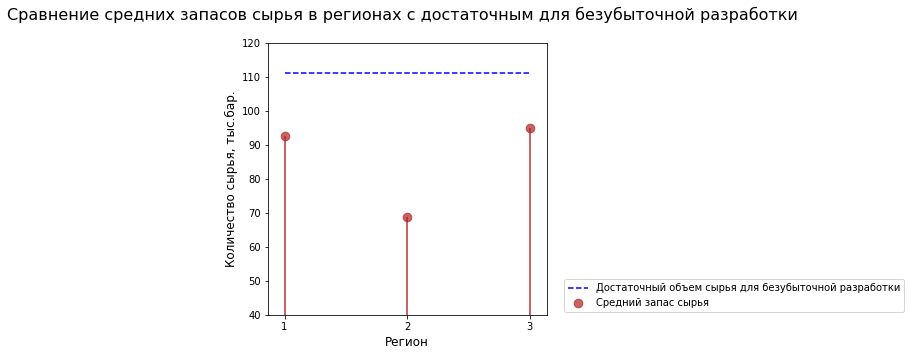

In [14]:
fig, ax = plt.subplots(figsize=(5,5))

ax.vlines(x=product_profit.index, ymin=0, ymax=product_profit['Cредний запас сырья'], color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=product_profit.index, y=product_profit['Cредний запас сырья'], s=75, color='firebrick', alpha=0.7, label='Cредний запас сырья')
ax.plot(product_profit.index, product_profit['Достаточный объем сырья для безубыточной разработки'], color='blue', linestyle = '--', label='Достаточный объем сырья для безубыточной разработки')

ax.set_xlabel('Регион', fontsize=12)
ax.set_ylabel('Количество сырья, тыс.бар.', fontsize=12)
ax.set_xticks(product_profit.index)
ax.set_ylim(40, 120)
ax.legend(bbox_to_anchor=(2.3, 0.15))

fig.suptitle('Сравнение средних запасов сырья в регионах с достаточным для безубыточной разработки', fontsize=16)
plt.show()

---

- Из графиков сырья видно, что средние запасы сырья по скважинам в регионах ниже достаточного для безубыточной добычи значения

---

---

- Напишем функцию для расчета прибыли по выбранным скважинам

---

In [15]:
warnings.filterwarnings('ignore')

def wells_income(target_product, predicted_product, wells_amount, product_income, total_budget):
    
    predicted_product_sort = predicted_product.sort_values(ascending=False)
    selected_target = target_product[predicted_product_sort.index][:wells_amount]
    income = selected_target.sum().astype('int64') * product_income
    
    return income - total_budget

    
best_wells_income_1 = wells_income(target_test_1, predicted_product_1, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)
best_wells_income_2 = wells_income(target_test_2, predicted_product_2, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)
best_wells_income_3 = wells_income(target_test_3, predicted_product_3, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)


data = {'Регион' : [1, 2, 3], 
        'Прибыль с 200 лучших скважин, млрд. руб.' : [best_wells_income_1*(10**-9), best_wells_income_2*(10**-9), best_wells_income_3*(10**-9)],
    }

best_wells_income = pd.DataFrame(data=data).set_index('Регион')

display(best_wells_income.sort_values(by='Прибыль с 200 лучших скважин, млрд. руб.', ascending=False).round(2))


,"Прибыль с 200 лучших скважин, млрд. руб."
Регион,
1,3.32
3,2.71
2,2.42


---

- По полученным предсказаниям моделей, наибольшая прибыль с 200 скважин с максимальным продуктом достигается в регионе 1, наименьшая - в регионе 2

---

# 4. Расчёт прибыли и рисков 

---

- Определим среднее значение прибыли, для этого воспользуемся техникой bootstrap, чтобы по множеству выборок оценить среднее значение распределения прибыли


---

In [16]:
fraction = SELECTED_WELLS_AMOUNT/len(predicted_product_1)

income_1 = []
income_2 = []
income_3 = []

state = np.random.RandomState(random_state)

for i in range(1000):
    
    target_product_sample_1 = target_test_1.sample(frac=fraction, replace=True, random_state=state)
    target_product_sample_2 = target_test_2.sample(frac=fraction, replace=True, random_state=state)
    target_product_sample_3 = target_test_3.sample(frac=fraction, replace=True, random_state=state)

    predicted_product_sample_1 = predicted_product_1[target_product_sample_1.index]
    predicted_product_sample_2 = predicted_product_2[target_product_sample_2.index]  
    predicted_product_sample_3 = predicted_product_3[target_product_sample_3.index]
    
    income_sample_1 = wells_income(target_product_sample_1, predicted_product_sample_1, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)
    income_sample_2 = wells_income(target_product_sample_2, predicted_product_sample_2, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)
    income_sample_3 = wells_income(target_product_sample_3, predicted_product_sample_3, BEST_WELLS_AMOUNT, PRODUCT_INCOME, TOTAL_BUDGET)
        
    income_1.append(income_sample_1)
    income_2.append(income_sample_2)
    income_3.append(income_sample_3)

income_1 = pd.Series(income_1)
income_2 = pd.Series(income_2)
income_3 = pd.Series(income_3)

income_mean_1 = income_1.mean()
income_mean_2 = income_2.mean()
income_mean_3 = income_3.mean()

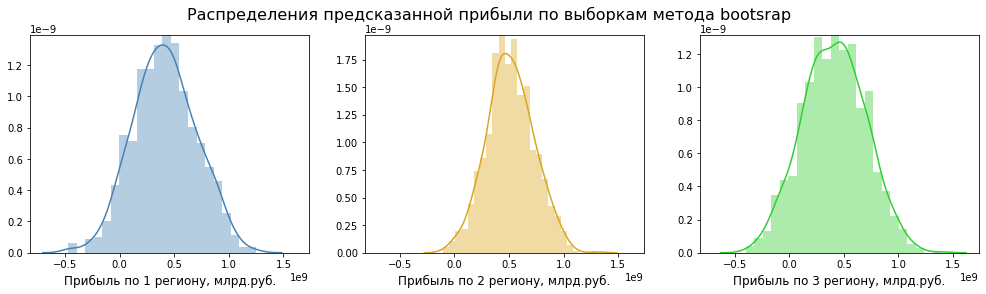

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17, 4), sharex=True)

sns.distplot(income_1, ax=ax1, color='steelblue')
sns.distplot(income_2, ax=ax2, color='goldenrod')
sns.distplot(income_3, ax=ax3, color='limegreen')

ax1.set_xlabel('Прибыль по 1 региону, млрд.руб.', fontsize=12)
ax2.set_xlabel('Прибыль по 2 региону, млрд.руб.', fontsize=12)
ax3.set_xlabel('Прибыль по 3 региону, млрд.руб.', fontsize=12)

fig.suptitle('Распределения предсказанной прибыли по выборкам метода bootsrap', fontsize=16)
plt.show()

---

- Рассчитаем риски убытков для каждого региона как долю случаев отрицательной прибыли

---

In [18]:
risk_1 = income_1.where(income_1<0).count() / income_1.count()
risk_2 = income_2.where(income_2<0).count() / income_2.count()
risk_3 = income_3.where(income_3<0).count() / income_3.count()

---

- Рассчитаем 95%-й доверительный интервал для каждого региона

---

In [19]:
interval_1 = []
interval_2 = []
interval_3 = []

interval_1.append(round(np.quantile(income_1, .025)*(10**-9), 2))
interval_2.append(round(np.quantile(income_2, .025)*(10**-9), 2))
interval_3.append(round(np.quantile(income_3, .025)*(10**-9), 2))

interval_1.append(round(np.quantile(income_1, 0.975)*(10**-9), 2))
interval_2.append(round(np.quantile(income_2, 0.975)*(10**-9), 2))
interval_3.append(round(np.quantile(income_3, 0.975)*(10**-9), 2))

In [20]:
data = {'Регион' : [1, 2, 3], 
        'Средняя прибыль, млрд.руб' : [income_mean_1*(10**-9), income_mean_2*(10**-9), income_mean_3*(10**-9)],
        'Риск убытков, %' : [risk_1*100, risk_2*100, risk_3*100],
        '95%-й доверительный интервал, млрд.руб' : [interval_1, interval_2, interval_3]
    }

regions_mean_income = pd.DataFrame(data=data).set_index('Регион')

display(regions_mean_income.sort_values(by='Средняя прибыль, млрд.руб', ascending=False).round(2))

,"Средняя прибыль, млрд.руб","Риск убытков, %","95%-й доверительный интервал, млрд.руб"
Регион,,,
2,0.51,0.9,"[0.08, 0.94]"
1,0.41,7.0,"[-0.12, 0.97]"
3,0.41,8.5,"[-0.14, 0.97]"


---

- Максимальное значение средней прибыли относится ко второму региону 


- Минимальные риски убытков соответсвуют модели первого и третьего региона


- Минимальный риск убытков относится ко второму региону, в остальных случаях риск убытков превышает допустимые 2.5%


- 95%-й доверительный интервал для второго региона составляют положительные значения прибыли

---

# 5. Общий вывод

---

- На основании вышеизложенных данных, можно выдвинуть предположение о том, что регион 2 является наиболее перспективным для разработки


- Основания для подобного решения следующие:

    1. Модель региона имет наименьшую ошибку

    2. Средняя прибыль на основании предсказаний модели является самой выоской среди всех регионов

    3. Риск убытков не превышает 1%

---